In [1]:
import matplotlib.pyplot as plt
from mplsoccer import Pitch, Sbopen, VerticalPitch
import pandas as pd

In [10]:
#open the data
parser = Sbopen()
df_match = parser.match(competition_id=223, season_id=282)
#our team
team = "Colombia"
#get list of games by our team, either home or away
match_ids = df_match.loc[(df_match["home_team_name"] == team) | (df_match["away_team_name"] == team)]["match_id"].tolist()
#calculate number of games
no_games = len(match_ids)
print(no_games)

6


In [11]:
danger_passes = pd.DataFrame()
df_lineup = pd.DataFrame()
for idx in match_ids:
    df = parser.event(idx)[0]
    new_lineup = parser.lineup(idx)
    new_lineup = new_lineup[new_lineup["team_name"] == team]
    df_lineup = pd.concat([df_lineup, new_lineup])
    
    for period in [1,2]:
        mask_pass = (df.team_name == team) & (df.type_name == "Pass") & (df.outcome_name.isnull()) & (df.period == period) & (df.sub_type_name.isnull())
        passes = df.loc[mask_pass, ['x', 'y', 'end_x', 'end_y', 'minute', 'second', 'player_name']]
        mask_shot = (df.team_name == team) & (df.type_name == "Shot") & (df.period == period)
        shots = df.loc[mask_shot, ['minute', 'second']]
        shot_times = shots['minute']*60+shots['second']
        shot_window = 15
        shot_start = shot_times - shot_window
        shot_start = shot_start.apply(lambda i: i if i>0 else (period-1)*45)
        pass_times = passes['minute'] * 60 + passes['second']
        pass_to_shot = pass_times.apply(lambda x: True in ((shot_start < x) & (x < shot_times)).unique())
        
        
        danger_passes_period = passes.loc[pass_to_shot]
        
        #concatenate dataframe with a previous one to keep danger passes from the whole tournament
        danger_passes = pd.concat([danger_passes, danger_passes_period], ignore_index = True)

In [13]:
df_lineup[df_lineup["player_name"].str.contains("James")]

,player_id,player_name,player_nickname,jersey_number,match_id,team_id,team_name,country_id,country_name
31,5695,James David Rodríguez Rubio,James Rodríguez,10,3943077,769,Colombia,49,Colombia
5,5695,James David Rodríguez Rubio,James Rodríguez,10,3942852,769,Colombia,49,Colombia
4,5695,James David Rodríguez Rubio,James Rodríguez,10,3942416,769,Colombia,49,Colombia
5,5695,James David Rodríguez Rubio,James Rodríguez,10,3939984,769,Colombia,49,Colombia
31,5695,James David Rodríguez Rubio,James Rodríguez,10,3939991,769,Colombia,49,Colombia
31,5695,James David Rodríguez Rubio,James Rodríguez,10,3939975,769,Colombia,49,Colombia


In [9]:
danger_passes.count()

x              148
y              148
end_x          148
end_y          148
minute         148
second         148
player_name    148
dtype: int64

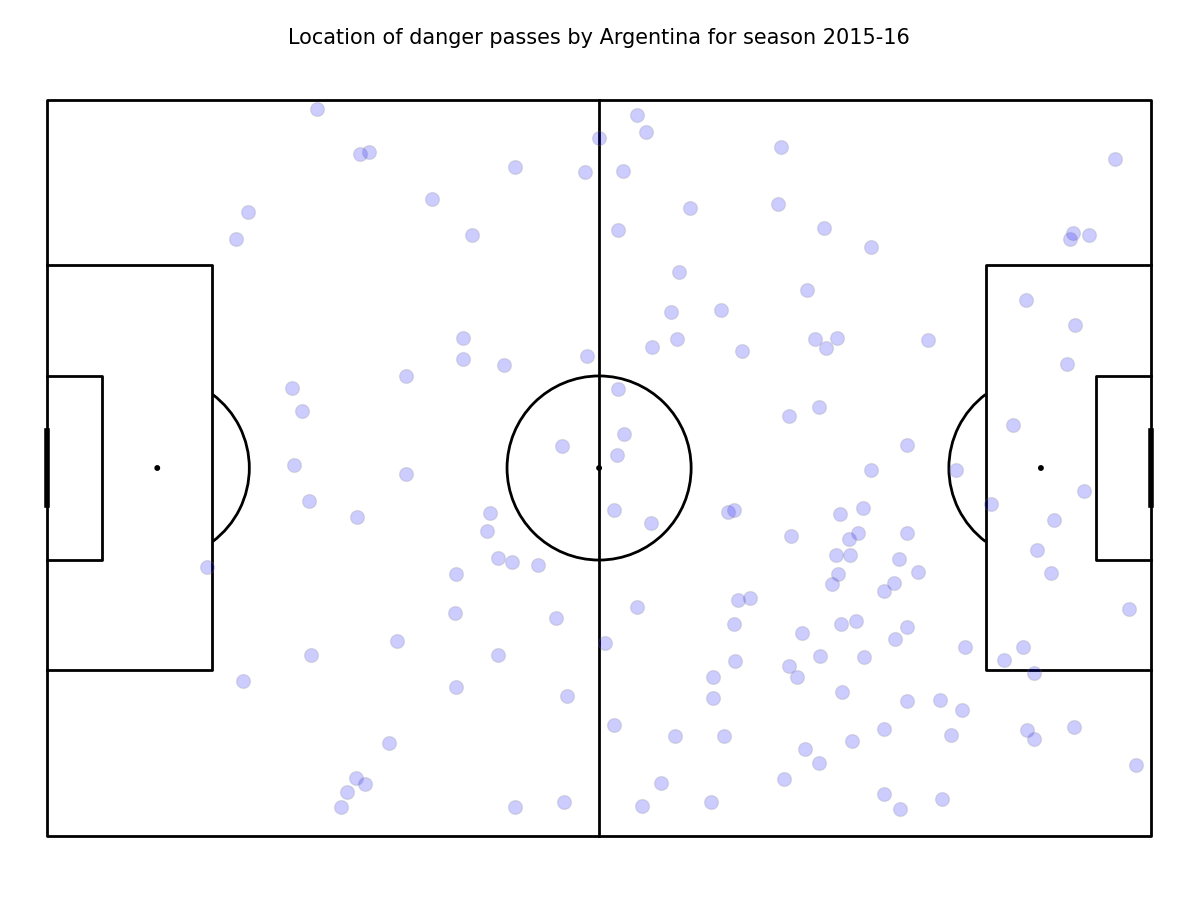

In [5]:
pitch = Pitch(line_color='black')
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)
#scatter the location on the pitch
pitch.scatter(danger_passes.x, danger_passes.y, s=100, color='blue', edgecolors='grey', linewidth=1, alpha=0.2, ax=ax["pitch"])
#uncomment it to plot arrows
#pitch.arrows(danger_passes.x, danger_passes.y, danger_passes.end_x, danger_passes.end_y, color = "blue", ax=ax['pitch'])
#add title
fig.suptitle('Location of danger passes by ' + team + ' for season 2023-24', fontsize = 15)
plt.show()


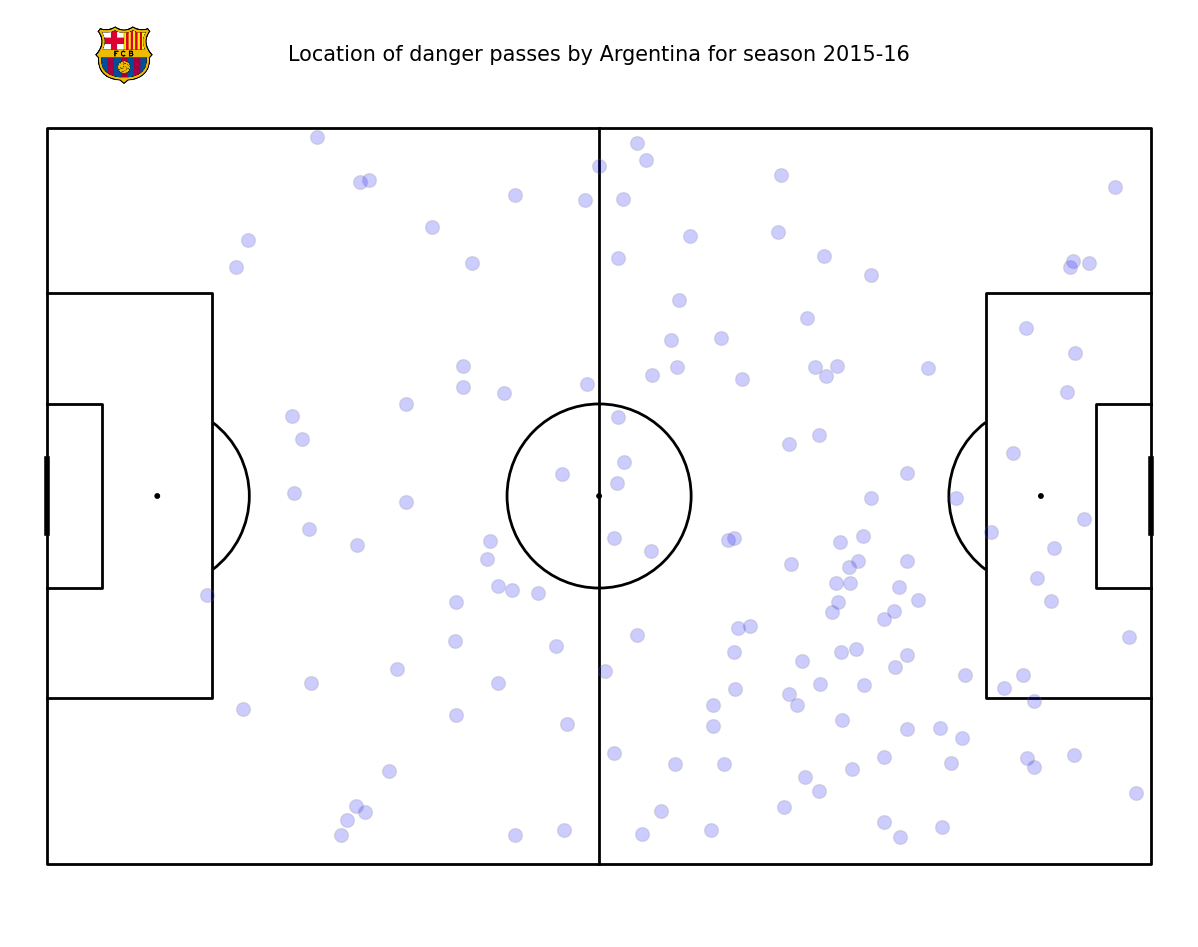

In [6]:
import matplotlib.pyplot as plt
from mplsoccer import Pitch
from urllib.request import urlopen
from PIL import Image
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

# URLs for logos
BARCA_LOGO_URL = ('https://upload.wikimedia.org/wikipedia/en/thumb/4/47/'
                  'FC_Barcelona_%28crest%29.svg/142px-FC_Barcelona_%28crest%29.svg.png')
# Load images
barca_logo = Image.open(urlopen(BARCA_LOGO_URL))

# Set up the pitch
pitch = Pitch(line_color='black')
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)

# Scatter the location on the pitch
ax["pitch"].scatter(danger_passes.x, danger_passes.y, s=100, color='blue', edgecolors='grey', linewidth=1, alpha=0.2)

# Function to add image to the plot
def add_image(img, fig, left, bottom, width=None, height=None):
    img = OffsetImage(img, zoom=0.3)
    if width is not None:
        img.set_width(width)
    if height is not None:
        img.set_height(height)
    ab = AnnotationBbox(img, (left, bottom), frameon=False, xycoords='figure fraction')
    fig.add_artist(ab)

# Add the logos to the plot
add_image(barca_logo, fig, left=0.1, bottom=0.991, height=0.1)

# Add title and subtitle
fig.suptitle('Location of danger passes by ' + team + ' for season 2015-16', fontsize=15, va="center")

plt.show()

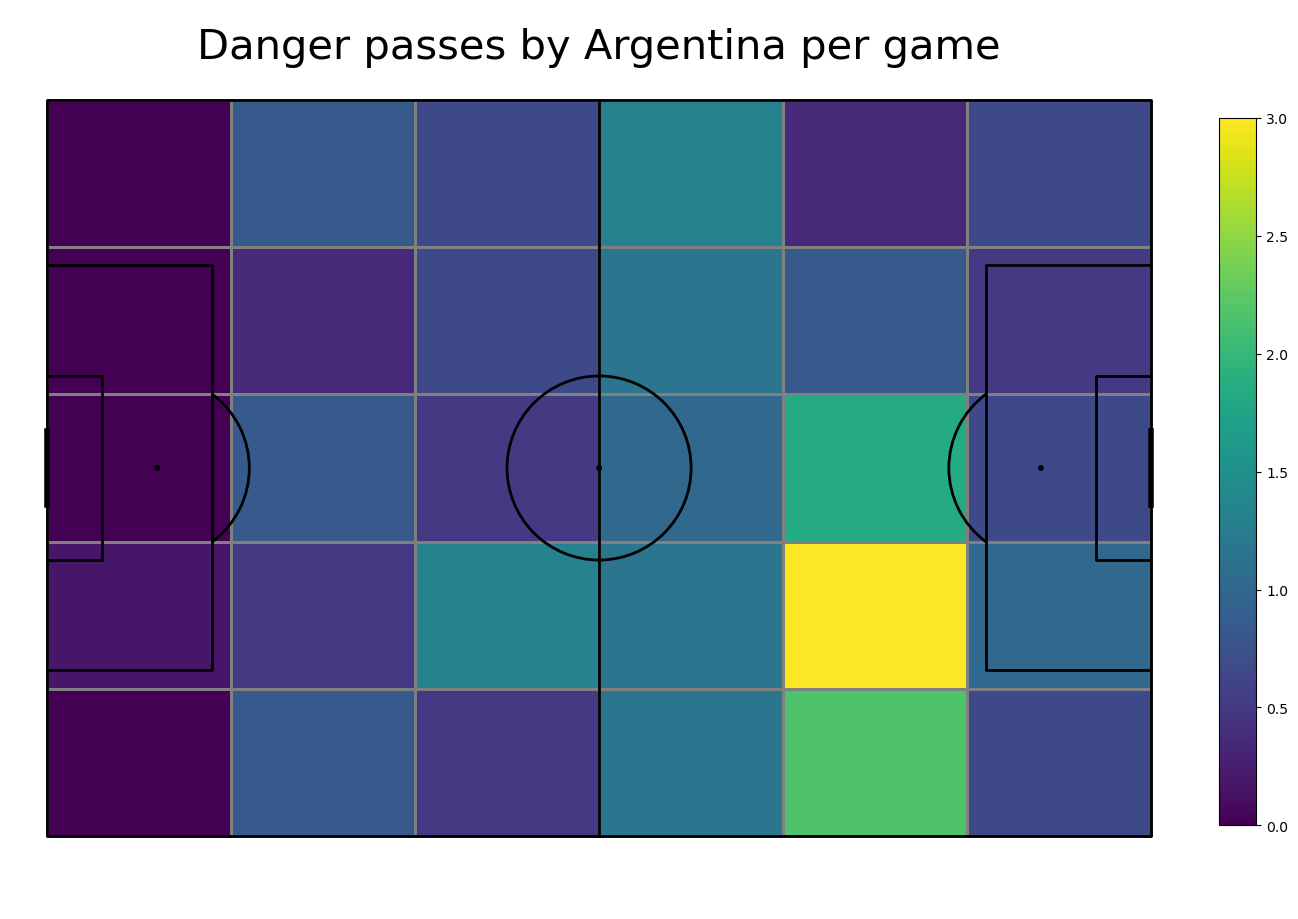

In [7]:
pitch = Pitch(line_zorder=2, line_color='black')
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)

bin_statistic = pitch.bin_statistic(danger_passes.x, danger_passes.y, statistic='count', bins=(6, 5), normalize=False)
bin_statistic["statistic"] = bin_statistic["statistic"]/no_games
#make a heatmap
pcm  = pitch.heatmap(bin_statistic, cmap='viridis', edgecolor='grey', ax=ax['pitch'])
#legend to our plot
ax_cbar = fig.add_axes((1, 0.093, 0.03, 0.786))
cbar = plt.colorbar(pcm, cax=ax_cbar)

add_image
fig.suptitle('Danger passes by ' + team + " per game", fontsize = 30)
plt.show()


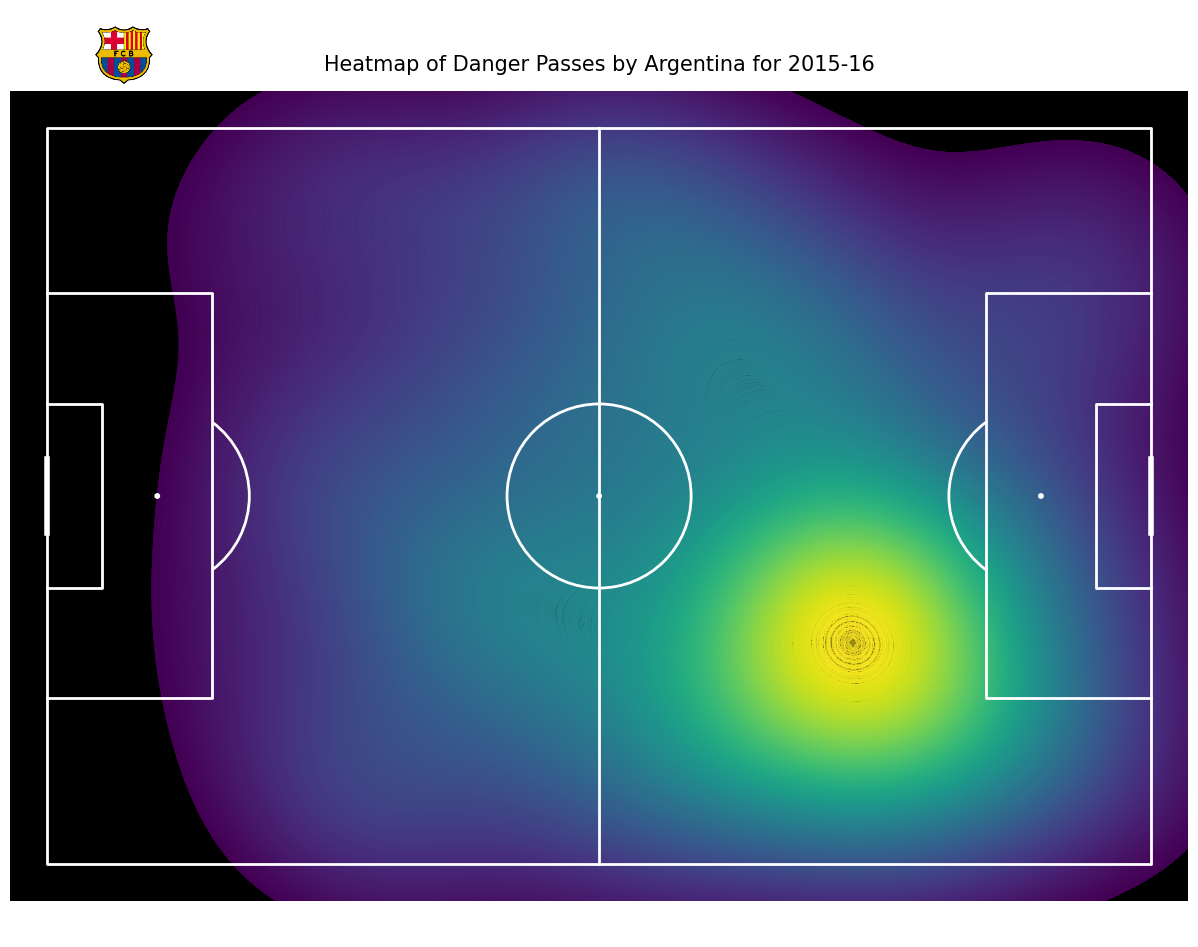

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
from mplsoccer import Pitch


# Assuming danger_passes contains data for all games in the season

# Example data (replace with your actual data)
all_x = danger_passes.x
all_y = danger_passes.y

# Create a pitch object
pitch = Pitch(line_zorder=2, line_color='white', pitch_color = 'black')

# Create figure and axis using pitch parameters
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)

# Calculate KDE (Kernel Density Estimation) for smoothing
sns.kdeplot(x=all_x, y=all_y, cmap = 'viridis', fill = True, ax=ax['pitch'], alpha=0.6, levels = 5000)



# Set title
add_image(barca_logo, fig, left=0.1, bottom=0.991, height=0.1)
fig.suptitle('Heatmap of Danger Passes by ' + team + " for 2015-16", fontsize=15)

# Show plot
plt.show()


In [24]:
df_lineup.drop_duplicates(subset = ['player_name', 'player_id'], inplace = True)

In [25]:
df_lineup.count()

player_id          27
player_name        27
player_nickname    27
jersey_number      27
match_id           27
team_id            27
team_name          27
country_id         27
country_name       27
dtype: int64

In [26]:
danger_passes = danger_passes.merge(df_lineup[["player_name","player_nickname"]], on="player_name", how = "left")

In [27]:
danger_passes.drop(columns=['player_name'], inplace = True)

In [28]:
danger_passes.rename(columns = {'player_nickname': 'player_name'}, inplace = True)

In [29]:
danger_passes

,x,y,end_x,end_y,minute,second,player_name
0,63.1,51.9,76.9,75.3,6,24,Gerard Piqué
1,74.4,75.3,76.3,67.9,6,26,Dani Alves
2,76.9,68.3,63.5,69.0,6,27,Sergi Roberto
3,62.7,68.6,72.1,73.9,6,30,Dani Alves
4,79.8,74.1,97.9,60.6,6,33,Sergi Roberto
...,...,...,...,...,...,...,...
1450,104.8,68.5,108.9,31.8,83,34,Ivan Rakitić
1451,72.1,32.8,91.2,68.8,84,10,Sergio Busquets
1452,116.8,67.8,106.0,40.5,84,17,Ivan Rakitić
1453,86.2,21.5,81.3,30.6,88,39,Javier Mascherano


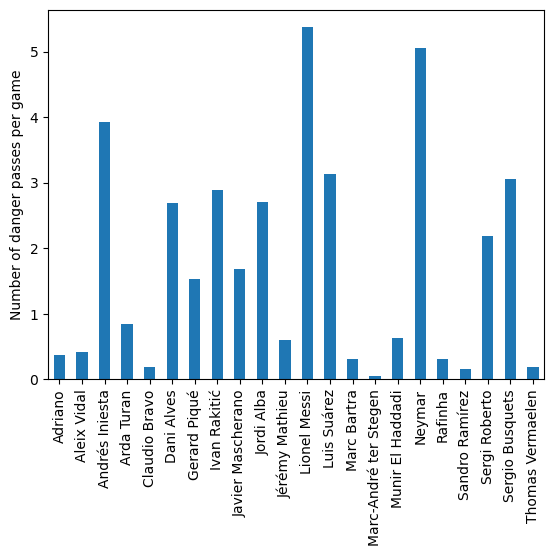

In [30]:
#count passes by player and normalize them
pass_count = danger_passes.groupby(['player_name']).x.count()/no_games
#make a histogram
ax = pass_count.plot.bar(pass_count)
#make legend
ax.set_xlabel("")
ax.set_ylabel("Number of danger passes per game")
plt.show()
